In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras import activations, optimizers, losses


## Cleaning and Preprocessing

### Load in the airline reviews database

In [2]:
df = pd.read_csv('sample_data/reviews.csv')

In [3]:
df.iloc[178]

Unnamed: 0                                                     178
index                                                          178
Datetime                                           13th April 2023
Name                                                      L Horten
OverallRating                                                  2.0
ReviewHeader                     "never fly British Airways again"
ReviewBody       I will never fly British Airways again. To sta...
Name: 178, dtype: object

Around 36% of reviews have no explicit header.

In [4]:
df.ReviewHeader.value_counts()/df.ReviewHeader.nunique()

British Airways customer review      0.356185
"never fly British Airways again"    0.002235
"Overall a good flight"              0.001863
"service was good"                   0.001118
"a very comfortable flight"          0.001118
                                       ...   
"arrived reasonably promptly"        0.000373
"very professional and pleasant"     0.000373
"a fantastic flight"                 0.000373
"onboard service was abysmal"        0.000373
"a very good overall service"        0.000373
Name: ReviewHeader, Length: 2684, dtype: float64

Where the Review Header is not given (is recorded as 'British Airways customer review'), the Review Body is often long winded and mixed in sentiment.

I will therefore discard these and focus on those with an explicit Review Header.

In [5]:
df[df['ReviewHeader'] == 'British Airways customer review'][['ReviewBody']].iloc[-1].ReviewBody

"SIN-LHR BA12 B747-436 First Class. Old aircraft (1998) with seats that are not that private but there are only a few of us in the cabin so ok. A bit tatty but I think the planes are being replaced by A380's soon. Seat itself is comfortable enough. Inflight Entertainment awful: fuzzy screen (low resolution LCD screen way passed it's sell-by date) with limited options. Inconveniently has to be pulled around to be seen and put away for t/off and landing. seat comfortable enough for sleeping. Food and service quintessentially English which is the only real reason to fly BA nowadays - the product just doesn't match other airlines. Toilet cramped and awful but it has a window!"

### Reduce the dataframe to just those columns of interest

In [6]:
reviews = df[['OverallRating', 'ReviewHeader']].copy()

In [7]:
#Remove 'British Airways customer review' headers.
reviews = reviews[reviews.ReviewHeader != 'British Airways customer review']
#Remove duplicate reviews with the same rating.
reviews.drop_duplicates(inplace= True)

Some reviews are identical but have different ratings.

In [8]:
reviews.ReviewHeader.value_counts()

"service was good"                3
"Boarding was chaotic"            2
"a positive experience"           2
"a waste of money"                2
"how the mighty have fallen"      2
                                 ..
"Flight was good"                 1
"Not good for business"           1
"behind the competition"          1
"staff exceptionally friendly"    1
"appears it was a window"         1
Name: ReviewHeader, Length: 2683, dtype: int64

In [9]:
reviews[reviews.ReviewHeader == '"a very comfortable flight"']

,OverallRating,ReviewHeader
87,9.0,"""a very comfortable flight"""
644,7.0,"""a very comfortable flight"""


In [10]:
# #Create a dictionary to store the number of unique rating for each review.
# rating_counts = dict(reviews.ReviewHeader.value_counts())
# #Create a list of just the reviews with multiple ratings.
# mult_ratings = [k for k in rating_counts if rating_counts[k] > 1]

In [11]:
#Create a new column with averaged ratings
reviews['AvgdRating'] = reviews['ReviewHeader'].map(lambda rev: int(np.mean(reviews[reviews.ReviewHeader == rev].OverallRating)))

In [12]:
# reviews[reviews.ReviewHeader == mult_ratings[0]]

In [13]:
#Remove OverallRating column
reviews.drop(columns='OverallRating', inplace=True)

In [14]:
#Drop duplicates again, now that we have averaged ratings across identical reviews.
reviews.drop_duplicates(inplace=True)

In [15]:
reviews.ReviewHeader.nunique()

2683

### Clean the reviews

In [16]:
import re
# from gensim.models.phrases import Phraser, Phrases

In [17]:
# for row in reviews['ReviewHeader']:
#     for match in re.findall('\S+1\S+', row):
#         print(match)

In [18]:
type(reviews[['ReviewHeader']].iloc[0].ReviewHeader)

str

In [19]:
# punctuation = list(string.punctuation)
# punctuation

In [20]:
def text_preprocessing(df, col_name):
  punctuation = list(string.punctuation)
  df[col_name] = df[col_name].apply(lambda rev: rev.lower())
  df[col_name] = df[col_name].apply(lambda rev: ''.join(x for x in rev if not(x in punctuation)))
  df[col_name] = df[col_name].str.replace('\d+', '')
  return(df)



In [21]:
reviews_cleaned = text_preprocessing(reviews, 'ReviewHeader').copy()

In [22]:
reviews_cleaned.head()

,ReviewHeader,AvgdRating
0,service level far worse then ryanair,1
1,do not upgrade members based on status,3
2,flight was smooth and quick,8
3,absolutely hopeless airline,1
4,customer service is non existent,1


## Tokenize reviews

In [23]:
reviews_cleaned

,ReviewHeader,AvgdRating
0,service level far worse then ryanair,1
1,do not upgrade members based on status,3
2,flight was smooth and quick,8
3,absolutely hopeless airline,1
4,customer service is non existent,1
...,...,...
2753,need to up their game,3
2754,our last flight with british airways,1
2755,supposed legacy airline,2
2756,staff amiable and present,7


In [24]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [25]:
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [26]:
reviews_tokenized = reviews_cleaned.copy()

In [27]:
reviews_cleaned.ReviewHeader[179]

'seats were cramped and uncomfortable'

<Axes: >

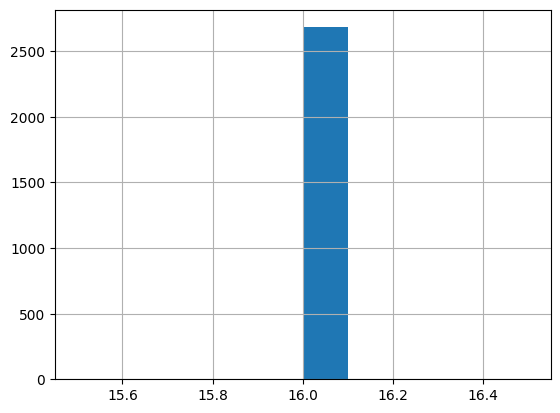

In [28]:
reviews_tokenized["ReviewHeader"] = reviews_tokenized["ReviewHeader"].map(lambda x: tokenizer(x, max_length=16, padding = "max_length", truncation = True, return_tensors="tf")["input_ids"].numpy()[0])

reviews_tokenized["ReviewHeader"].map(lambda x: len(x)).hist()



In [29]:
reviews_tokenized.ReviewHeader

0       [101, 2326, 2504, 2521, 4788, 2059, 4575, 1121...
1       [101, 2079, 2025, 12200, 2372, 2241, 2006, 357...
2       [101, 3462, 2001, 5744, 1998, 4248, 102, 0, 0,...
3       [101, 7078, 20625, 8582, 102, 0, 0, 0, 0, 0, 0...
4       [101, 8013, 2326, 2003, 2512, 25953, 102, 0, 0...
                              ...                        
2753    [101, 2342, 2000, 2039, 2037, 2208, 102, 0, 0,...
2754    [101, 2256, 2197, 3462, 2007, 2329, 13095, 102...
2755    [101, 4011, 8027, 8582, 102, 0, 0, 0, 0, 0, 0,...
2756    [101, 3095, 26445, 3085, 1998, 2556, 102, 0, 0...
2757    [101, 3685, 6346, 1996, 2326, 102, 0, 0, 0, 0,...
Name: ReviewHeader, Length: 2683, dtype: object

In [30]:
# tokenized_tensors = tokenizer(reviews_cleaned['ReviewHeader'].tolist(), max_length=16, padding = "max_length", truncation = True, return_tensors="tf")

In [31]:
# reviews_tokenized['ReviewHeader'] = tokenized_tensors.input_ids.numpy()

In [32]:
# for i in range(179):
#   try:
#     if not(tokenized_tensors['input_ids'][i] == reviews_tokenized.ReviewHeader[i].all()):
#       print(i)
#   except: None

## Using DistilBert Model (positive/negative) - needs cleaning up.

In [33]:
type(reviews_tokenized['AvgdRating'].to_list())

list

In [34]:
reviews_tokenized['PosNeg'] = reviews_tokenized['AvgdRating'].apply(lambda x: 0 if x < 3 else 1)

We need to check if the classes are balanced

In [35]:
reviews_tokenized.PosNeg.value_counts()
class_count_1, class_count_0 = reviews_tokenized['PosNeg'].value_counts()

In [76]:
class_1_sample = reviews_tokenized[reviews_tokenized.PosNeg == 1].sample(class_count_0)


In [83]:
reviews_tok_sample = pd.concat([reviews_tokenized[reviews_tokenized.PosNeg == 0], class_1_sample], axis=0)

In [84]:
reviews_tok_sample.PosNeg.value_counts()

0    1063
1    1063
Name: PosNeg, dtype: int64

<Axes: xlabel='AvgdRating', ylabel='Count'>

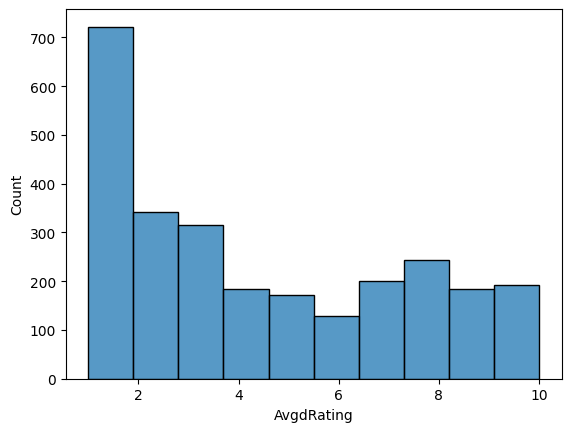

In [86]:
sns.histplot(reviews_cleaned['AvgdRating'], bins= 10)

In [38]:
# reviews_tokenized[reviews_tokenized['PosNeg'] == 0].AvgdRating.value_counts()
# reviews_tokenized

In [87]:
len(reviews_tok_sample['PosNeg']), len(reviews_tok_sample['ReviewHeader'])

(2126, 2126)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(reviews_tok_sample['ReviewHeader'], reviews_tok_sample['PosNeg'], test_size=0.33, random_state=42)

In [89]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1424,), (702,), (1424,), (702,))

In [90]:
def frmt_cstm_tf(ser):
  output = tf.convert_to_tensor(np.array([list(arr) for arr in ser]))
  return output

In [91]:
X_train_tf = frmt_cstm_tf(X_train)
X_test_tf = frmt_cstm_tf(X_test)


In [92]:
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

In [94]:
# X_train_tf, y_train_tf, X_test_tf, y_test_tf

In [94]:
#optimizer = optimizers.Adam(learning_rate=0.1)

In [95]:
#opt = tf.optimizers.Adam(learning_rate=0.01)

In [95]:
tf_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

tf_model.compile(optimizer= 'adam', metrics= "accuracy")

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [96]:
X_train_tf[223]

<tf.Tensor: shape=(16,), dtype=int32, numpy=
array([  101,  2000,  4875,  2000,  4487,  3736,  9397, 25785,   102,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)>

In [97]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [98]:
tf_model.fit(X_train_tf, y_train_tf, validation_split=0.2, batch_size=32, epochs=5)

Epoch 1/5
36/36 [==============================] - 39s 260ms/step - loss: 0.8318 - accuracy: 0.4917 - val_loss: 1.2973 - val_accuracy: 0.4421
Epoch 2/5
36/36 [==============================] - 4s 114ms/step - loss: 0.7166 - accuracy: 0.4969 - val_loss: 0.6867 - val_accuracy: 0.5579
Epoch 3/5
36/36 [==============================] - 3s 94ms/step - loss: 0.6953 - accuracy: 0.5031 - val_loss: 0.6887 - val_accuracy: 0.5579
Epoch 4/5
36/36 [==============================] - 3s 87ms/step - loss: 0.6951 - accuracy: 0.4917 - val_loss: 0.6917 - val_accuracy: 0.5579
Epoch 5/5
36/36 [==============================] - 3s 91ms/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6944 - val_accuracy: 0.4421


In [99]:
tf_model.evaluate(X_test_tf, y_test_tf)

22/22 [==============================] - 1s 29ms/step - loss: 0.6929 - accuracy: 0.5157


[0.6928786039352417, 0.5156695246696472]

In [ ]:
# tf_model.predict(np.expand_dims(X_test[0], 0))

In [100]:
example = "Amazing"

In [101]:
ex_input = tokenizer(example, return_tensors='tf').input_ids

In [102]:
tokenizer.decode(ex_input[0])

'[CLS] amazing [SEP]'

In [103]:
tf_model.predict(ex_input)

1/1 [==============================] - 4s 4s/step


TFSequenceClassifierOutput(loss=None, logits=array([[-0.03952568, -0.06001017]], dtype=float32), hidden_states=None, attentions=None)